In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
##%pip install tensorflow==2.2
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model


In [3]:
import datetime
import random
import math
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
fallas = pd.read_excel('Serie de tiempo ERP52001.xlsx')

In [5]:
fallas.head(5)

,FECHA,PT52001E.F.,PT52001S.F.,Mes,Semana,Dia,Hora,DIF
0,2020-01-01 00:00:00,49.422585,18.170101,1,1,1,0,31.252483
1,2020-01-01 00:05:00,49.843132,18.267963,1,1,1,0,31.575169
2,2020-01-01 00:10:00,49.573982,18.235344,1,1,1,0,31.338638
3,2020-01-01 00:15:00,49.489876,18.202721,1,1,1,0,31.287155
4,2020-01-01 00:20:00,49.506699,18.170101,1,1,1,0,31.336597


In [6]:
df = fallas.iloc[:,0:3]

In [8]:
df.head(5)

,FECHA,PT52001E.F.,PT52001S.F.
0,2020-01-01 00:00:00,49.422585,18.170101
1,2020-01-01 00:05:00,49.843132,18.267963
2,2020-01-01 00:10:00,49.573982,18.235344
3,2020-01-01 00:15:00,49.489876,18.202721
4,2020-01-01 00:20:00,49.506699,18.170101


In [9]:
df = df.rename(columns={'PT52001E.F.':'PRESION_ENTRADA','PT52001S.F.':'PRESION_SALIDA'})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120509 entries, 0 to 120508
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   FECHA            120509 non-null  datetime64[ns]
 1   PRESION_ENTRADA  120509 non-null  float64       
 2   PRESION_SALIDA   120509 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.8 MB


In [10]:
df.describe()

,PRESION_ENTRADA,PRESION_SALIDA
count,120509.000000,120509.000000
mean,46.338041,21.421346
std,4.456813,4.047239
min,-0.999000,-0.999000
25%,44.325569,18.034401
50%,46.949776,19.083500
75%,49.439407,24.817039
max,52.097260,49.731842


In [13]:
np.percentile(df['PRESION_ENTRADA'],0.20)

0.0841092318296433

In [11]:
df['PRESION_ENTRADA'][df['PRESION_ENTRADA']<10].count()

436

In [17]:
plt.plot(df['PRESION_SALIDA'])

In [15]:
%matplotlib qt

In [65]:
#df.set_index('FECHA',inplace=True)

In [78]:
plt.plot(df['FECHA'],df['PRESION_SALIDA'],df['FECHA'],df['PRESION_ENTRADA'])

In [21]:
df.head(5)

,FECHA,PRESION_SALIDA
0,2020-01-01 00:00:00,18.170101
1,2020-01-01 00:05:00,18.267963
2,2020-01-01 00:10:00,18.235344
3,2020-01-01 00:15:00,18.202721
4,2020-01-01 00:20:00,18.170101


In [20]:
df = df.loc[:,['FECHA','PRESION_SALIDA']]

In [22]:
train, test = df.loc[df['FECHA'] <= datetime.datetime(2021, 3, 2, 0,0)], df.loc[df['FECHA'] > datetime.datetime(2021, 3, 2, 0,0)]


In [23]:
test.shape

(253, 2)

In [24]:
scaler = StandardScaler()
scaler = scaler.fit(train[['PRESION_SALIDA']])

In [25]:
train['PRESION_SALIDA'] = scaler.transform(train[['PRESION_SALIDA']])
test['PRESION_SALIDA'] = scaler.transform(test[['PRESION_SALIDA']])

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
seq_size = 100 

def to_sequences(x, y, seq_size):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['PRESION_SALIDA']], train['PRESION_SALIDA'], seq_size)
testX, testY = to_sequences(test[['PRESION_SALIDA']], test['PRESION_SALIDA'], seq_size)

In [27]:
trainX.shape

(120156, 100, 1)

In [17]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 100, 64)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100, 64)           33024     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 128)          98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 1)            129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

In [28]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [29]:
history = model.fit(trainX, trainY, epochs=12, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/12
3380/3380 [==============================] - 440s 130ms/step - loss: 0.1105 - val_loss: 0.1109
Epoch 2/12
3380/3380 [==============================] - 480s 142ms/step - loss: 0.0996 - val_loss: 0.0958
Epoch 3/12
3380/3380 [==============================] - 481s 142ms/step - loss: 0.0960 - val_loss: 0.0904
Epoch 4/12
3380/3380 [==============================] - 467s 138ms/step - loss: 0.0945 - val_loss: 0.0948
Epoch 5/12
3380/3380 [==============================] - 492s 146ms/step - loss: 0.0937 - val_loss: 0.0897
Epoch 6/12
3380/3380 [==============================] - 429s 127ms/step - loss: 0.0928 - val_loss: 0.0954
Epoch 7/12
3380/3380 [==============================] - 464s 137ms/step - loss: 0.0922 - val_loss: 0.0918
Epoch 8/12
3380/3380 [==============================] - 458s 135ms/step - loss: 0.0917 - val_loss: 0.0892
Epoch 9/12
3380/3380 [==============================] - 459s 136ms/step - loss: 0.0916 - val_loss: 0.0900
Epoch 10/12
3380/3380 [=======================

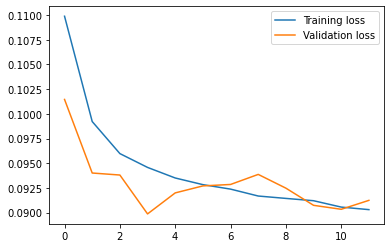

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [42]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)  #or Define 90% value of max as threshold.

(array([3.8546e+04, 1.2682e+04, 1.3272e+04, 1.4883e+04, 1.4138e+04,
        1.2956e+04, 9.4780e+03, 1.5580e+03, 6.5300e+02, 3.5300e+02,
        3.2200e+02, 2.7800e+02, 2.5900e+02, 1.4900e+02, 8.7000e+01,
        6.9000e+01, 6.5000e+01, 1.1800e+02, 6.2000e+01, 6.4000e+01,
        4.6000e+01, 3.5000e+01, 4.3000e+01, 1.8000e+01, 9.0000e+00,
        4.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.00836872, 0.24753194, 0.48669516, 0.72585839, 0.96502161,
        1.20418483, 1.44334805, 1.68251127, 1.92167449, 2.16083771,
        2.40000093, 2.63916415, 2.87832737, 3.11749059, 3.35665381,
        3.59581703, 3.83498025, 4.07414347, 4.31330669, 4.55246991,
        4.79163313, 5.03079635, 5.26995957, 5.50912279, 5.74828601,
        5.98744924, 6.22661246, 6.46577568, 6.7049389 , 6.94410212,
        7.18326534]),
 <a list of 30 Patch objects>)

In [52]:
plt.hist(trainMAE, bins=30)

(array([3.8546e+04, 1.2682e+04, 1.3272e+04, 1.4883e+04, 1.4138e+04,
        1.2956e+04, 9.4780e+03, 1.5580e+03, 6.5300e+02, 3.5300e+02,
        3.2200e+02, 2.7800e+02, 2.5900e+02, 1.4900e+02, 8.7000e+01,
        6.9000e+01, 6.5000e+01, 1.1800e+02, 6.2000e+01, 6.4000e+01,
        4.6000e+01, 3.5000e+01, 4.3000e+01, 1.8000e+01, 9.0000e+00,
        4.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.00836872, 0.24753194, 0.48669516, 0.72585839, 0.96502161,
        1.20418483, 1.44334805, 1.68251127, 1.92167449, 2.16083771,
        2.40000093, 2.63916415, 2.87832737, 3.11749059, 3.35665381,
        3.59581703, 3.83498025, 4.07414347, 4.31330669, 4.55246991,
        4.79163313, 5.03079635, 5.26995957, 5.50912279, 5.74828601,
        5.98744924, 6.22661246, 6.46577568, 6.7049389 , 6.94410212,
        7.18326534]),
 <a list of 30 Patch objects>)

In [35]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

(array([47.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  2.,  4.,  4.,
         2.,  3.,  3.,  2.,  4.,  3.,  3.,  6.,  6.,  7.,  4.,  3.,  3.,
         3.,  1.,  8.,  6.]),
 array([0.08869312, 0.13963445, 0.19057577, 0.2415171 , 0.29245842,
        0.34339974, 0.39434107, 0.44528239, 0.49622372, 0.54716504,
        0.59810636, 0.64904769, 0.69998901, 0.75093034, 0.80187166,
        0.85281298, 0.90375431, 0.95469563, 1.00563696, 1.05657828,
        1.1075196 , 1.15846093, 1.20940225, 1.26034358, 1.3112849 ,
        1.36222622, 1.41316755, 1.46410887, 1.5150502 , 1.56599152,
        1.61693284]),
 <a list of 30 Patch objects>)

In [64]:
plt.hist(testMAE, bins=30)

(array([47.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  2.,  4.,  4.,
         2.,  3.,  3.,  2.,  4.,  3.,  3.,  6.,  6.,  7.,  4.,  3.,  3.,
         3.,  1.,  8.,  6.]),
 array([0.08869312, 0.13963445, 0.19057577, 0.2415171 , 0.29245842,
        0.34339974, 0.39434107, 0.44528239, 0.49622372, 0.54716504,
        0.59810636, 0.64904769, 0.69998901, 0.75093034, 0.80187166,
        0.85281298, 0.90375431, 0.95469563, 1.00563696, 1.05657828,
        1.1075196 , 1.15846093, 1.20940225, 1.26034358, 1.3112849 ,
        1.36222622, 1.41316755, 1.46410887, 1.5150502 , 1.56599152,
        1.61693284]),
 <a list of 30 Patch objects>)

In [65]:
max_trainMAE = 1.5

In [66]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['PRESION_SALIDA'] = test[seq_size:]['PRESION_SALIDA']

In [67]:
anomaly_df[anomaly_df['anomaly']==True].count()

FECHA             15
PRESION_SALIDA    15
testMAE           15
max_trainMAE      15
anomaly           15
dtype: int64

In [68]:
sns.lineplot(x=anomaly_df['FECHA'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['FECHA'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [70]:
sns.lineplot(x=anomaly_df['FECHA'], y=scaler.inverse_transform(anomaly_df['PRESION_SALIDA']))
sns.scatterplot(x=anomalies['FECHA'], y=scaler.inverse_transform(anomalies['PRESION_SALIDA']), color='r')